<h1 align=center><font size = 8>Data Science Capstone Project</font></h1>
<h1 align=center><font size = 8>A Comparison of Dallas and Fort Worth</font></h1>

## Introduction
<blockquote>It is often said that Dallas is where the east ends and Fort Worth is where the west begins.  Certainly, it is true that when you think of Fort Worth, you think of pickup trucks and cowboy boots and Billy Bob's at The Stockyards and when you think of Dallas, you think of BMW's and banking and Highland Park.  The question for someone who's company has recently moved to the DFW area, though, is:  is there a difference in the neighborhoods in Fort Worth and Dallas?</blockquote>
<blockquote>This project will use Zillow nighborhood data to see if there are any systematic differences in Dallas vs. Fort Worth nighborhoods using k-means clustering.</blockquote>

We will start by loading the libraries that we need for this project.

In [493]:
try:
    import pandas as pd
    import numpy as np
except:
    !conda install -c anaconda pandas numpy --yes 
    import pandas as pd
    import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
try:
    from geopy.geocoders import Nominatim # to convert address into latitude and longitude
except:
    !conda install -c conda-forge geopy --yes 
    from geopy.geocoders import Nominatim
try:
    import folium # plotting library
except:
    !conda install -c conda-forge folium --yes 
    import folium
from bs4 import BeautifulSoup
import urllib.request
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import geojson
!conda activate geo1
from shapely.geometry import Point, Polygon

In [494]:
!conda activate geo1
from shapely.geometry import Point, Polygon

## Data
The geodata used for this project is the Zillow US Neighborhoods dataset.  Zillow makes this data available for free under a creative commons licence.  It can be downloaded at "https://data.opendatasoft.com/explore/dataset/zillow-neighborhoods%40public/export/".
<br>
<br>
We used the export filters and downloaded one geojson file for Fort Worth and a second geojson file for Dallas.  The files contain full geoshape data and has "properties" sections that that contain the city, neighborhood name, regionid, geo_point_2d, county and state.  We parse the files to just load the properties section and append it to a dataframe.  We then split the geo_data_2d entry into Latitude and Longitude columns, dropping any rows where geo_data_2d is NA.


In [950]:
with open('e:/downloads/zillow-neighborhoods-FortWorth.geojson') as json_data:
    fortworth_neighborhood_data = geojson.load(json_data)
with open('e:/downloads/zillow-neighborhoods-Dallas.geojson') as json_data:
    dallas_neighborhood_data = geojson.load(json_data)
print(type(fortworth_neighborhood_data), type(dallas_neighborhood_data))

<class 'geojson.feature.FeatureCollection'> <class 'geojson.feature.FeatureCollection'>


In [951]:
print(type(fortworth_neighborhood_data[0]['geometry']['coordinates'][0]))
print(fortworth_neighborhood_data[0]['geometry']['coordinates'][0])
print(fortworth_neighborhood_data['features'][0])

<class 'list'>
[[-97.428271, 32.645946], [-97.428288, 32.645946], [-97.428367, 32.645944], [-97.428685, 32.645933], [-97.429647, 32.645984], [-97.4302, 32.646044], [-97.430962, 32.646061], [-97.432542, 32.646125], [-97.43244, 32.648147], [-97.428821, 32.648459], [-97.428535, 32.647886], [-97.428396, 32.647557], [-97.428318, 32.647253], [-97.428249, 32.646923], [-97.42824, 32.646541], [-97.428271, 32.645946]]
{"geometry": {"coordinates": [[[-97.428271, 32.645946], [-97.428288, 32.645946], [-97.428367, 32.645944], [-97.428685, 32.645933], [-97.429647, 32.645984], [-97.4302, 32.646044], [-97.430962, 32.646061], [-97.432542, 32.646125], [-97.43244, 32.648147], [-97.428821, 32.648459], [-97.428535, 32.647886], [-97.428396, 32.647557], [-97.428318, 32.647253], [-97.428249, 32.646923], [-97.42824, 32.646541], [-97.428271, 32.645946]]], "type": "Polygon"}, "properties": {"city": "Fort Worth", "county": "Tarrant", "geo_point_2d": [32.64714146486756, -97.43035652827258], "name": "Briercliff", "r

In [952]:
fortworth_neighborhood_data_slice = fortworth_neighborhood_data['features']
df = pd.DataFrame(columns=['city','name','regionid','geo_point_2d','county','state'])
df_coordinates = pd.DataFrame(columns=['coordinates'])
for entry in fortworth_neighborhood_data_slice:
    df = df.append(entry['properties'],ignore_index=True)
    df_coordinates = df_coordinates.append(entry['geometry'],ignore_index=True)
dallas_neighborhood_data_slice = dallas_neighborhood_data['features']
for entry in dallas_neighborhood_data_slice:
    df = df.append(entry['properties'],ignore_index=True)
    df_coordinates = df_coordinates.append(entry['geometry'],ignore_index=True)
df = df.rename(columns={'name': 'Neighborhood'})
df['coordinates']=df_coordinates['coordinates']
df.head()

,city,Neighborhood,regionid,geo_point_2d,county,state,coordinates
0,Fort Worth,Briercliff,422763,"[32.64714146486756, -97.43035652827258]",Tarrant,TX,"[[[-97.428271, 32.645946], [-97.428288, 32.645..."
1,Fort Worth,Fairmount,233172,"[32.724372978687654, -97.33766189387364]",Tarrant,TX,"[[[-97.34377, 32.718042], [-97.34377, 32.71804..."
2,Fort Worth,Willow Creek,207722,"[32.63110091743264, -97.3434603767844]",Tarrant,TX,"[[[-97.348532, 32.634888], [-97.34777, 32.6348..."
3,Fort Worth,Shaw Clarke,422871,"[32.70111450603923, -97.33719612060821]",Tarrant,TX,"[[[-97.33749, 32.70601], [-97.33749, 32.705724..."
4,Fort Worth,Carver Heights,422820,"[32.72505076405124, -97.22932078449055]",Tarrant,TX,"[[[-97.228473, 32.725718], [-97.228222, 32.725..."


Split up geo_point_2d into Latitude and Longitude

In [953]:
print(df.shape)
df = df.dropna(subset=['geo_point_2d'])
print(df.shape)
df2 = pd.DataFrame(df["geo_point_2d"].tolist(), columns=['Latitude','Longitude']) #pd.DataFrame(df['geo_point_2d'].tolist(),index=df.index)
df = pd.concat([df, df2], axis=1)
df.drop(['geo_point_2d'],axis=1,inplace=True)
df.head()

(425, 7)
(425, 7)


,city,Neighborhood,regionid,county,state,coordinates,Latitude,Longitude
0,Fort Worth,Briercliff,422763,Tarrant,TX,"[[[-97.428271, 32.645946], [-97.428288, 32.645...",32.647141,-97.430357
1,Fort Worth,Fairmount,233172,Tarrant,TX,"[[[-97.34377, 32.718042], [-97.34377, 32.71804...",32.724373,-97.337662
2,Fort Worth,Willow Creek,207722,Tarrant,TX,"[[[-97.348532, 32.634888], [-97.34777, 32.6348...",32.631101,-97.343460
3,Fort Worth,Shaw Clarke,422871,Tarrant,TX,"[[[-97.33749, 32.70601], [-97.33749, 32.705724...",32.701115,-97.337196
4,Fort Worth,Carver Heights,422820,Tarrant,TX,"[[[-97.228473, 32.725718], [-97.228222, 32.725...",32.725051,-97.229321


In [954]:
# load zillow home prices
home_prices = pd.read_csv('Neighborhood_Zhvi_AllHomes.csv')
print(home_prices.shape)
df['regionid'] = df['regionid'].astype('int')
print(type(df['regionid'][0]))
home_prices = pd.merge(df,home_prices, left_on='regionid', right_on='RegionID', how='left')
home_prices.head()
#dfw_venues.head()

(16147, 301)
<class 'numpy.int32'>


,city,Neighborhood,regionid,county,state,coordinates,Latitude,Longitude,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30
0,Fort Worth,Briercliff,422763,Tarrant,TX,"[[[-97.428271, 32.645946], [-97.428288, 32.645...",32.647141,-97.430357,422763.0,16533.0,Briercliff,Neighborhood,TX,TX,Fort Worth,Dallas-Fort Worth-Arlington,Tarrant County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,277005.0,275131.0,273246.0,269484.0,266984.0,264742.0,263505.0,261248.0,259602.0,258853.0,260550.0,262156.0,263092.0,263038.0,263664.0,265627.0,267315.0,269675.0,270991.0,274175.0,27

Extract Dallas-Fort Worth

In [955]:
#dfw = df[df['city'].isin(['Dallas', 'Fort Worth'])]
dfw = df.copy()
dfw.drop(['regionid'],axis=1,inplace=True)
dfw.sort_values(['city','Neighborhood'], inplace=True, ignore_index=True)
print(dfw.shape)
dfw.groupby("city").count()

(425, 7)


,Neighborhood,county,state,coordinates,Latitude,Longitude
city,,,,,,
Carrollton,21,21,21,21,21,21
Dallas,34,34,34,34,34,34
Desoto,6,6,6,6,6,6
Fort Worth,225,225,225,225,225,225
Garland,85,85,85,85,85,85
Irving,18,18,18,18,18,18
Mesquite,4,4,4,4,4,4
Plano,1,1,1,1,1,1
Richardson,31,31,31,31,31,31


# Methodology
##  Visual Inspection:  Create a map of DFW Neighborhoods

In [956]:
# create map - use Arlington for map lat/long
address = 'Arlington, TX'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Arlington are {}, {}.'.format(latitude, longitude))
# using point slightly north to get centering right
latitude =32.791825
longitude = -97.03

The geograpical coordinate of Arlington are 32.701938999999996, -97.10562379033699.


In [957]:
# create map of DFW using latitude and longitude values for Arlington
map_dfw = folium.Map(location=[latitude, longitude], zoom_start=10, control_scale=True)

# add markers to map
for lat, lng, city, neighborhood in zip(dfw['Latitude'], dfw['Longitude'], dfw['city'], dfw['Neighborhood']):
    label = '{}, {}, {}, {}'.format(neighborhood, city, lat, lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dfw)  
map_dfw.save('DFW_Neighborhoods.html')  
map_dfw

# Get Neighborhood Venues

In [958]:
CLIENT_ID = 'YPF4NY2VJMYEMROHWYBYVI11IZKQ0H4EDECKGJR0XDYRWE4M' # your Foursquare ID
CLIENT_SECRET = 'LI202HN0RHIHWIIQQPWSYIPUQE14DLGSNALI21B5XGV4E31Y' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1200 #1600 approx 1 mile, 500 approx .3 mile

In [959]:
def getVenuesInPolygon(names, latitudes, longitudes, polygons):
    file_handle=open('coordinates.csv','w')
    radius=8000
    venues_list=[]
    for name, lat, lng, poly in zip(names, latitudes, longitudes, polygons):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        #try:    
        # make the GET request
        #results = requests.get(url).json()["response"]['groups'][0]['items']
        results = requests.get(url).json()["response"]
        if len(results)>0:
            results = results['groups'][0]['items']
            while len(poly)>0 and len(poly)<3:
                poly = poly[0]
            try:
                coordinates = Polygon(poly)
            except:
                try:
                    coordinates = Polygon(poly[0])
                except:
                    try:
                        coordinates = Polygon(poly[0][0])
                    except:
                        print(name," Invalid coordinates: length: ",len(poly),' coordinates: ', poly)
                        file_handle.write(name," Invalid coordinates: length: ",len(poly),' coordinates: ')
                        file_handle.write(poly)            
            # return only relevant information for each nearby venue
            #print(results)
            venue_count = 0
            for v in results:
                pt = Point([v['venue']['location']['lng'],v['venue']['location']['lat']])
                #if (coordinates.length>0 and pt.within(coordinates)) or (coordinates.length==0 and v['venue']['location']['distance']<800):
                if (coordinates.length>0 and pt.within(coordinates)) or v['venue']['location']['distance']<800:
                    venue_count = venue_count + 1
                    #print(pt,' inside ',coordinates)
                    venues_list.append([name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],  
                        v['venue']['categories'][0]['name']])
                #else:
                #    print(pt,' outside ',coordinates)
            print(name, lat, lng, ' venue count ', venue_count)            
            if venue_count==0:
                print('\tno venues')
                venues_list.append([
                    name, 
                lat, 
                    lng, 
                    'Residential', 
                    lat, 
                    lng,  
                    'Residential'
                    ])
            
        else:
            print(name, lat, lng,' No groups in results')
            venues_list.append([
                    name, 
                    lat, 
                    lng, 
                    'Residential', 
                    lat, 
                    lng,  
                    'Residential'
                    ])
                  
        #except:
        #    print('\tProblem getting info')
    #print('venues_list:  ',venues_list)  
    nearby_venues = pd.DataFrame(venues_list, columns=['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 
        'Venue Longitude', 'Venue Category']) 
    #nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    #nearby_venues = pd.DataFrame(columns = ['Neighborhood', 
    #              'Neighborhood Latitude', 
    #              'Neighborhood Longitude', 
    #              'Venue', 
    #              'Venue Latitude', 
    #              'Venue Longitude', 
    #              'Venue Category'])
    file_handle.close()
    return(nearby_venues)

In [960]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        try:    
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            print('\tProblem getting info')
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [961]:
#dfw_venues = getNearbyVenues(names=dfw['Neighborhood'],latitudes=dfw['Latitude'],longitudes=dfw['Longitude'],radius)
#print(dfw['coordinates'].iloc[:5])
radius=3200
#dfw_venues = getVenuesInPolygon(names=dfw['Neighborhood'].iloc[:5],latitudes=dfw['Latitude'].iloc[:5],longitudes=dfw['Longitude'].iloc[:5],
#    polygons=dfw['coordinates'].iloc[:5])
dfw_venues = getVenuesInPolygon(names=dfw['Neighborhood'],latitudes=dfw['Latitude'],longitudes=dfw['Longitude'],polygons=dfw['coordinates'])
#print (dfw_venues.head())
print('There are {} unique categories.'.format(len(dfw_venues['Venue Category'].unique())))

Bel Air of Josey Ranch 32.969355914257726 -96.88168631227494  venue count  0
	no venues
Cambridge Estates 32.988927644291394 -96.91617820375673  venue count  0
	no venues
Carrollton Heights 32.956817736977484 -96.90127455361676  venue count  0
	no venues
Carrollton Summertree 32.97278590625278 -96.86834792754553  venue count  0
	no venues
Carrolton Highlands 32.951421190068444 -96.89745971865148  venue count  0
	no venues
Hill'n Dale 32.9652324227805 -96.89314077922661  venue count  0
	no venues
Jackson Arms 32.97657242364724 -96.89296428247056  venue count  0
	no venues
Mcoy Estates 32.98105765762574 -96.89554645640186  venue count  0
	no venues
Morningside 32.98840829897419 -96.87152296182454  venue count  0
	no venues
Nob Hill 32.98963477794778 -96.89570633349281  venue count  0
	no venues
Oak Tree North 32.98817469682512 -96.86008121492931  venue count  0
	no venues
Park Terrace 32.96294828979307 -96.9049947817715  venue count  0
	no venues
Parks of Carrollton 32.97653456989962 -96

In [962]:
dfw_venues.loc[dfw_venues['Venue Category']=='Zoo Exhibit']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
49,Cedar Crest,32.71831,-96.788708,Dallas Zoological Society,32.740868,-96.814195,Zoo Exhibit


In [963]:
# load and merge Venue Groups
venue_groups = pd.read_csv('VenueGroups.csv')
venue_groups.head()
if 'Venue Group' in dfw_venues.columns:
    dfw_venues.drop('Venue Group',axis=1, inplace=True)
dfw_venues = dfw_venues.join(venue_groups.set_index('Venue Category'), on='Venue Category')
dfw_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Group
0,Bel Air of Josey Ranch,32.969356,-96.881686,Residential,32.969356,-96.881686,Residential,Residential
1,Cambridge Estates,32.988928,-96.916178,Residential,32.988928,-96.916178,Residential,Residential
2,Carrollton Heights,32.956818,-96.901275,Residential,32.956818,-96.901275,Residential,Residential
3,Carrollton Summertree,32.972786,-96.868348,Residential,32.972786,-96.868348,Residential,Residential
4,Carrolton Highlands,32.951421,-96.897460,Residential,32.951421,-96.897460,Residential,Residential


In [964]:
dfw_venues[dfw_venues['Venue Category']=='Discount Store']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Group
177,Lake Highlands,32.893643,-96.754631,Nordstrom Rack,32.868091,-96.769055,Discount Store,Shopping Venues
320,Northeast Dallas,32.845409,-96.714138,Dollar Tree,32.834805,-96.702150,Discount Store,Shopping Venues
510,Southeast Dallas,32.711816,-96.664079,Dollar General,32.734970,-96.702222,Discount Store,Shopping Venues
513,Southeast Dallas,32.711816,-96.664079,Dollar General,32.747185,-96.647554,Discount Store,Shopping Venues
524,Southeast Dallas,32.711816,-96.664079,Family Dollar,32.735434,-96.650046,Discount Store,Shopping Venues
525,Southeast Dallas,32.711816,-96.664079,Family Dollar,32.738342,-96.684454,Discount Store,Shopping Venues
528,Southeast Dallas,32.711816,-96.664079,Family Dollar,32.712608,-96.684990,Discount Store,Shopping Venues
574,Winnetka Heights,32.736942,-96.893228,Dollar General,32.706146,-96.898775,Discount Store,Shopping Venues
584,Wolf Creek,32.658400,-96.846397,Dollar Tree,32.686501,-96.826845,Discount Store,Shopping Venues
669,Eagle Ranch,32.867056,-97.432239,Dollar General,32.866188,-97.426940,Discount Store,Shopping Venues


In [965]:
# make sure all venue categories have been assigned to venue groups
dfw_venues[dfw_venues['Venue Group']=='']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Group


In [966]:
# subroutine to write formated dataframe to html
def write_to_html(df, title='', filename='out.html'):
    result = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <title>Capstone Final Project</title>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no">
    <script src="https://code.jquery.com/jquery-3.4.1.slim.min.js" integrity="sha384-J6qa4849blE2+poT4WnyKhv5vZF5SrPo0iEjwBvKU7imGFAV0wwj1yYfoRSJoZ+n" crossorigin="anonymous"></script>
    <script src="https://cdn.jsdelivr.net/npm/popper.js@1.16.0/dist/umd/popper.min.js" integrity="sha384-Q6E9RHvbIyZFJoft+2mJbHaEWldlvI9IOYy5n3zV9zzTtmI3UksdQRVvoxMfooAo" crossorigin="anonymous"></script>
    
    <!-- Bootstrap CSS  v4 -->
    <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.4.1/css/bootstrap.min.css" integrity="sha384-Vkoo8x4CGsO3+Hhxv8T/Q5PaXtkKtu6ug5TOeNV6gBiFeWPGFN9MuhOf23Q9Ifjh" crossorigin="anonymous">
    <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css">
    <script src="https://stackpath.bootstrapcdn.com/bootstrap/4.4.1/js/bootstrap.min.js" integrity="sha384-wfSDF2E50Y2D1uUdj0O3uMBJnjuUD4Ih7YwaYd1iqfktj0Uod8GCExl3Og8ifwB6" crossorigin="anonymous"></script>
    
	<link rel="stylesheet" href="css/style.css">
</head>
<body>
    '''
    result += '<h2 class="text-center"> %s </h2>\n' % title
    if type(df) == pd.io.formats.style.Styler:
        result += df.render()
    else:
        result += df.to_html(index=False, justify="center",classes="table table-bordered mx_auto",escape=False)
    result += '''
</body>
</html>
'''
    with open(filename, 'w') as f:
        f.write(result)

In [967]:
# write venue groups to html file
fname = "VenueGroups.html"
title = "Venue Groups"
write_to_html(venue_groups[['Venue Group', 'Venue Category']].sort_values(['Venue Group', 'Venue Category']), title, fname)
#with  open(fname,"w") as file_handle:
#    file_handle.write(venue_groups[['Venue Group', 'Venue Category']].sort_values(['Venue Group', 'Venue Category']).to_html())
#venue_groups.head()
#venue_groups[['Venue Group', 'Venue Category']].sort_values(['Venue Group', 'Venue Category']).head()

In [968]:
print(dfw_venues.groupby('Neighborhood').count())

Neighborhood Latitude  \
Neighborhood                                               
Alamo Heights                                          3   
Alexandra Meadows                                      1   
Almeta,Bonita, Bella Vista                             1   
Altemesa East                                          1   
Apollo Arapaho & Camelot                               1   
Arapaho                                                1   
Arbor Creek                                            1   
Arcadia Park                                           1   
Arlington Heights                                      7   
Arts District                                          6   
Avondale                                               1   
Bal Harbour                                            1   
Basswood Park                                          1   
Basswood Village                                       1   
Bear Creek                                             8   
Beechwood Creek

# Analyze Neighborhoods

In [969]:
# one hot encoding
dfw_onehot = pd.get_dummies(dfw_venues[['Venue Category']], prefix="", prefix_sep="")
# There is Neighborhood in the venue categories, so we drop that column
try:
    del dfw_onehot['Neighborhood']
except:
    print('No venues called Neighborhood')
# add neighborhood column back to dataframe
dfw_onehot['Neighborhood'] = dfw_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dfw_onehot.columns[-1]] + list(dfw_onehot.columns[:-1])
dfw_onehot = dfw_onehot[fixed_columns]
dfw_onehot.head()

,Neighborhood,Airport Service,American Restaurant,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Big Box Store,Boat or Ferry,Bookstore,Botanical Garden,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Butcher,Café,Cajun / Creole Restaurant,Campground,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Country Dance Club,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Event Space,Farmers Market,Fast Food Restaurant,Flea Market,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Herbs & Spices Store,High School,Hockey Rink,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Motorcycle Shop,Motorsports Shop,Movie Theater,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Pool,Public Art,Recreation Center,Residential,Resort,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Bel Air of Josey Ranch,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Cambridge Estates,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Carrollton Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Carrollton Summertree,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Carrolton Highlands,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [970]:
dfw_grouped = dfw_onehot.groupby('Neighborhood').mean().reset_index()
dfw_grouped.head()

,Neighborhood,Airport Service,American Restaurant,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Big Box Store,Boat or Ferry,Bookstore,Botanical Garden,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Butcher,Café,Cajun / Creole Restaurant,Campground,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Country Dance Club,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Event Space,Farmers Market,Fast Food Restaurant,Flea Market,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Herbs & Spices Store,High School,Hockey Rink,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Motorcycle Shop,Motorsports Shop,Movie Theater,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Pool,Public Art,Recreation Center,Residential,Resort,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Alamo Heights,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alexandra Meadows,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Almeta,Bonita, Bella Vista",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

# Group most common venues in each neighborhood

In [971]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
top_venue_columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        top_venue_columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        top_venue_columns.append('{}th Most Common Venue'.format(ind+1))
#define similar function for top venues by cluster
def return_most_common_venues_bycluster(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues_by_cluster = 5

# create columns according to number of top venues by cluster
top_venue_columns_bycluster = ['Cluster']
for ind in np.arange(num_top_venues_by_cluster):
    try:
        top_venue_columns_bycluster.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        top_venue_columns_bycluster.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=top_venue_columns)
neighborhoods_venues_sorted['Neighborhood'] = dfw_grouped['Neighborhood']

for ind in np.arange(dfw_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dfw_grouped.iloc[ind, :], num_top_venues)
    for col in range(num_top_venues):
        if dfw_grouped.set_index('Neighborhood').loc[[neighborhoods_venues_sorted.iloc[ind, 0]],[neighborhoods_venues_sorted.iloc[ind, 1+col]]].iloc[0][0] == 0:
            neighborhoods_venues_sorted.iloc[ind, 1+col] = 'NA'
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alamo Heights,Dessert Shop,BBQ Joint,Diner,NA,NA,NA,NA,NA,NA,NA
1,Alexandra Meadows,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,"Almeta,Bonita, Bella Vista",Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,Altemesa East,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,Apollo Arapaho & Camelot,Butcher,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [972]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 6

dfw_grouped_clustering = dfw_grouped.drop('Neighborhood', axis=1)
if 'Cluster' in neighborhoods_venues_sorted.columns:
    neighborhoods_venues_sorted.drop('Cluster',axis=1, inplace=True)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dfw_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster', kmeans.labels_)
dfw_merged = dfw.copy()

# merge merge with venues to add latitude/longitude for each neighborhood
dfw_merged = dfw_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

dfw_merged.head()

,city,Neighborhood,county,state,coordinates,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Carrollton,Bel Air of Josey Ranch,Dallas,TX,"[[[-96.884675, 32.967425], [-96.884703, 32.969...",32.969356,-96.881686,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,Carrollton,Cambridge Estates,Dallas,TX,"[[[-96.913294, 32.990296], [-96.910004, 32.990...",32.988928,-96.916178,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,Carrollton,Carrollton Heights,Dallas,TX,"[[[-96.906652, 32.955414], [-96.906635, 32.956...",32.956818,-96.901275,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,Carrollton,Carrollton Summertree,Dallas,TX,"[[[-96.864348, 32.97025], [-96.867828, 32.9702...",32.972786,-96.868348,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,Carrollton,Carrolton Highlands,Dallas,TX,"[[[-96.890407, 32.95367], [-96.890393, 32.9496...",32.951421,-96.897460,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA


## check for invalid cluster labels

In [973]:
idx = pd.to_numeric(dfw_merged['Cluster'], errors='coerce').isna()
print('Number of neighborhoods with invalid Clusters: ',len(dfw_merged[idx]), ' out of ',len(dfw_merged.index))
#neighborhoods_venues_sorted[idx]

dfw_merged[idx]

Number of neighborhoods with invalid Clusters:  0  out of  425


,city,Neighborhood,county,state,coordinates,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


## Map clusters--removing rows with invalid cluster labels and converting cluster labels to int before we map them

In [974]:

# first, we have to drop non-numeric clusters and change them to int
dfw_merged = dfw_merged[pd.to_numeric(dfw_merged['Cluster'], errors='coerce').notnull()]
dfw_merged['Cluster'] = dfw_merged['Cluster'].astype('int')
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10,control_scale=True)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow2=['#0000ff','#800080','#ff964f','#ff0000','#008000','#ffd700','#1996f3','#663300','#ffc0cb','#daa520','#ff00ff','#9efd38','#808000','#008080','#800000','#000080'] 
rainbow_text=['blue','purple','orange','red','green','yellow','sky blue','brown','pink','gold','fuchsia','lime','olive','teal','maroon','navy']
#create a dataframe to be used later
color_df = pd.DataFrame(rainbow_text)
color_df.columns = ['Color']
color_df['Cluster'] = color_df.index
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfw_merged['Latitude'], dfw_merged['Longitude'], dfw_merged['Neighborhood'], dfw_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow2[cluster],
        fill=True,
        fill_color=rainbow2[cluster],
        fill_opacity=0.7).add_to(map_clusters)
title_html = '''
            <h3 align="center" style="font-size:20px"><b>DFW Neighborhoods by Venue Category</b></h3>
            '''
map_clusters.get_root().html.add_child(folium.Element(title_html))
map_clusters.save('DFW_by_VenueCategory.html') 
map_clusters

## Examine cluster composition

In [975]:
dfw_merged.groupby('Cluster').count()

,city,Neighborhood,county,state,coordinates,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster,,,,,,,,,,,,,,,,,
0,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101
1,306,306,306,306,306,306,306,306,306,306,306,306,306,306,306,306,306
2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
3,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


In [976]:
# create a dataframe to store information about the clusters
clusters_by_category = pd.DataFrame(dfw_merged.groupby('Cluster')['city'].count())
#cluster_count['CountByGroup']=cluster_count['city']
clusters_by_category.columns = ['Count By Group']
clusters_by_category = clusters_by_category.merge(color_df, left_index=True, right_index=True)
#del cluster_count['Cluster']
# get count by cluster and merge
df = pd.DataFrame(dfw_merged.groupby('Cluster')['city'].count())
#cluster_count['CountByGroup']=cluster_count['city']
df.columns = ['Neighborhoods']
clusters_by_category = clusters_by_category.merge(df, left_index=True, right_index=True)
clusters_by_category = clusters_by_category[['Cluster','Color', 'Neighborhoods']]

clusters_by_category

,Cluster,Color,Neighborhoods
0,0,blue,101
1,1,purple,306
2,2,orange,2
3,3,red,7
4,4,green,4
5,5,yellow,5


In [977]:
# get most common venues by cluster
venues_bycluster = dfw_venues.copy()
venues_bycluster = pd.merge(venues_bycluster, dfw_merged[['Neighborhood', 'Cluster']], on='Neighborhood', how='outer', indicator=False)
venues_bycluster = venues_bycluster[[venues_bycluster.columns[-1]] + list(venues_bycluster.columns[:-1])]
venues_bycluster.head()
# one hot encoding
cluster_onehot = pd.get_dummies(venues_bycluster[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
cluster_onehot['Cluster'] = venues_bycluster['Cluster'] 
# move neighborhood column to the first column
fixed_columns = [cluster_onehot.columns[-1]] + list(cluster_onehot.columns[:-1])
cluster_onehot = cluster_onehot[fixed_columns]
group_bycluster = cluster_onehot.groupby('Cluster').mean().reset_index()
cluster_venues_sorted = pd.DataFrame(columns=top_venue_columns_bycluster)
cluster_venues_sorted['Cluster'] = group_bycluster['Cluster']
for ind in np.arange(group_bycluster.shape[0]):
    cluster_venues_sorted.iloc[ind, 1:] = return_most_common_venues_bycluster(group_bycluster.iloc[ind, :], num_top_venues_by_cluster)
    for col in range(num_top_venues_by_cluster):
        if group_bycluster.set_index('Cluster').loc[[cluster_venues_sorted.iloc[ind, 0]],[cluster_venues_sorted.iloc[ind, 1+col]]].iloc[0][0] == 0:
            cluster_venues_sorted.iloc[ind, 1+col] = ''
#group_bycluster.head()
cluster_venues_sorted.head(15)


,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Mexican Restaurant,Fast Food Restaurant,Burger Joint,Coffee Shop,Grocery Store
1,1,Residential,,,,
2,2,Thai Restaurant,,,,
3,3,Pharmacy,Italian Restaurant,,,
4,4,Golf Course,,,,
5,5,Convenience Store,Burger Joint,Mexican Restaurant,,


In [978]:
dfw_clustering_bycategory.shape
dfw_grouped.head()

,Neighborhood,Airport Service,American Restaurant,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Big Box Store,Boat or Ferry,Bookstore,Botanical Garden,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Butcher,Café,Cajun / Creole Restaurant,Campground,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Country Dance Club,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Event Space,Farmers Market,Fast Food Restaurant,Flea Market,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Herbs & Spices Store,High School,Hockey Rink,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Motorcycle Shop,Motorsports Shop,Movie Theater,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Pool,Public Art,Recreation Center,Residential,Resort,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Alamo Heights,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alexandra Meadows,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Almeta,Bonita, Bella Vista",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [979]:
# get the average percentage of the groups by cluster
dfw_clustering_bycategory =dfw_grouped.copy()
# add clustering labels
dfw_clustering_bycategory.insert(0, 'Cluster', kmeans.labels_)
dfw_clustering_bycategory = dfw_clustering_bycategory.groupby('Cluster').mean()
average_venues_by_cluster = pd.DataFrame(columns=top_venue_columns_bycluster)
average_venues_by_cluster['Cluster'] = group_bycluster['Cluster']
# get top groups
for ind in np.arange(dfw_clustering_bycategory.shape[0]):
    average_venues_by_cluster.iloc[ind, 1:] = get_top_venues_w_pcnt(dfw_clustering_bycategory.iloc[ind, :], num_top_venues_by_cluster,1)
average_venues_by_cluster

,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Mexican Restaurant-7%,Park-5%,Burger Joint-4%,Ice Cream Shop-3%,Grocery Store-3%
1,1,Residential-100%,,,,
2,2,Thai Restaurant-100%,,,,
3,3,Pharmacy-90%,Italian Restaurant-10%,,,
4,4,Golf Course-100%,,,,
5,5,Convenience Store-80%,Burger Joint-10%,Mexican Restaurant-10%,,


In [980]:
# join tables
clusters_by_category = clusters_by_category.join(average_venues_by_cluster.set_index('Cluster'), on='Cluster')
# add link to cluster listings and save file
clusters_by_category['Neighborhood List'] = clusters_by_category.apply(lambda row: '<a href="Cluster-ByCategory-' + str(row.Cluster) + '-' + str(kclusters) + '.html"'  + 'target="_blank">Cluster ' + str(row.Cluster) + ' neighborhoods</a>',axis=1)
fname = "Clusters_By_Category.html"
title = 'Clusters By Category'
write_to_html(clusters_by_category,title,fname)
#with  open(fname,"w") as file_handle:
#        file_handle.write(clusters_by_category.to_html(index=False, justify="center",classes="table table-bordered",escape=False))


In [981]:
clusters_by_category

,Cluster,Color,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Neighborhood List
0,0,blue,101,Mexican Restaurant-7%,Park-5%,Burger Joint-4%,Ice Cream Shop-3%,Grocery Store-3%,"<a href=""Cluster-ByCategory-0-6.html""target=""_..."
1,1,purple,306,Residential-100%,,,,,"<a href=""Cluster-ByCategory-1-6.html""target=""_..."
2,2,orange,2,Thai Restaurant-100%,,,,,"<a href=""Cluster-ByCategory-2-6.html""target=""_..."
3,3,red,7,Pharmacy-90%,Italian Restaurant-10%,,,,"<a href=""Cluster-ByCategory-3-6.html""target=""_..."
4,4,green,4,Golf Course-100%,,,,,"<a href=""Cluster-ByCategory-4-6.html""target=""_..."
5,5,yellow,5,Convenience Store-80%,Burger Joint-10%,Mexican Restaurant-10%,,,"<a href=""Cluster-ByCategory-5-6.html""target=""_..."


In [982]:
# write clusters to html files
for f in range(kclusters):
    fname = "Cluster-ByCategory-" + str(f) + "-" + str(kclusters) + ".html"
    title = "Cluster By Category: " +str(f) + " of " + str(kclusters)
    fst_venue_col = 7
    cluster_df = dfw_merged.loc[dfw_merged['Cluster'] == f, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])
    write_to_html(cluster_df, title, fname)
    #with  open(fname,"w") as file_handle:
    #    file_handle.write(cluster_df.to_html())

In [983]:
dfw_merged.loc[dfw_merged['Neighborhood']=='Wolf Creek']

,city,Neighborhood,county,state,coordinates,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
54,Dallas,Wolf Creek,Dallas,TX,"[[[-96.823164, 32.654073], [-96.823078, 32.641...",32.6584,-96.846397,0,Fast Food Restaurant,BBQ Joint,Convenience Store,Hardware Store,General Entertainment,Chinese Restaurant,Fried Chicken Joint,Paper / Office Supplies Store,Mexican Restaurant,Pet Store


In [984]:
dfw_merged.loc[dfw_merged['Cluster'] == 0, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Dallas,Arts District,0,Art Museum,Performing Arts Venue,Opera House,Theater,Concert Hall,NA,NA,NA,NA,NA
22,Dallas,Bluffview,0,Mexican Restaurant,American Restaurant,Grocery Store,Salon / Barbershop,Seafood Restaurant,Thai Restaurant,French Restaurant,Halal Restaurant,Fast Food Restaurant,Restaurant
24,Dallas,Cedar Crest,0,Zoo Exhibit,Zoo,Wings Joint,BBQ Joint,Southern / Soul Food Restaurant,Sandwich Place,Fried Chicken Joint,Grocery Store,Skating Rink,NA
25,Dallas,City Center District,0,Taco Place,NA,NA,NA,NA,NA,NA,NA,NA,NA
26,Dallas,Convention Center District,0,Plaza,Hotel,NA,NA,NA,NA,NA,NA,NA,NA
27,Dallas,Coppell,0,Burger Joint,Seafood Restaurant,NA,NA,NA,NA,NA,NA,NA,NA
29,Dallas,Eagle Ford,0,Mexican Restaurant,Hotel,Coffee Shop,Taco Place,Event Space,Restaurant,Trail,Bakery,Hotel Bar,Juice Bar
30,Dallas,Far North,0,Mexican Restaurant,Fast Food Restaurant,Restaurant,Nail Salon,Sushi Restaurant,Italian Restaurant,Tex-Mex Restaurant,Mediterranean Restaurant,Sports Bar,Coffee Shop
31,Dallas,Far North,0,Mexican Restaurant,Fast Food Restaurant,Restaurant,Nail Salon,Sushi Restaurant,Italian Restaurant,Tex-Mex Restaurant,Mediterranean Restaurant,Sports Bar,Coffee Shop
32,Dallas,Farmers Market District,0,Coffee Shop,Farmers Market,Hotel,Garden Center,NA,NA,NA,NA,NA,NA


In [985]:
dfw_merged.loc[dfw_merged['Cluster'] == 1, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Carrollton,Bel Air of Josey Ranch,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,Carrollton,Cambridge Estates,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,Carrollton,Carrollton Heights,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,Carrollton,Carrollton Summertree,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,Carrollton,Carrolton Highlands,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,Carrollton,Hill'n Dale,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,Carrollton,Jackson Arms,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,Carrollton,Mcoy Estates,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
8,Carrollton,Morningside,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
9,Carrollton,Nob Hill,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [986]:
dfw_merged.loc[dfw_merged['Cluster'] == 2, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Carrollton,Rohton Park,2,Thai Restaurant,NA,NA,NA,NA,NA,NA,NA,NA,NA
76,Fort Worth,Bonnie Brae,2,Thai Restaurant,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [987]:
dfw_merged.loc[dfw_merged['Cluster'] == 3, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Dallas,Buckner Terrace,3,Pharmacy,NA,NA,NA,NA,NA,NA,NA,NA,NA
227,Fort Worth,Sendera Ranch,3,Pharmacy,NA,NA,NA,NA,NA,NA,NA,NA,NA
228,Fort Worth,Sendera Ranch,3,Pharmacy,NA,NA,NA,NA,NA,NA,NA,NA,NA
229,Fort Worth,Sendera Ranch,3,Pharmacy,NA,NA,NA,NA,NA,NA,NA,NA,NA
237,Fort Worth,South Poly,3,Pharmacy,NA,NA,NA,NA,NA,NA,NA,NA,NA
268,Fort Worth,Villages of Woodland Springs,3,Italian Restaurant,Pharmacy,NA,NA,NA,NA,NA,NA,NA,NA
269,Fort Worth,Vista Meadows,3,Pharmacy,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [988]:
dfw_merged.loc[dfw_merged['Cluster'] == 4, dfw_merged.columns[[0,1] + list(range(6, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
102,Fort Worth,Colonial Hills,-97.371822,4,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
108,Fort Worth,Crestline Area,-97.387387,4,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
170,Fort Worth,Lost Creek,-97.524046,4,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
179,Fort Worth,Mira Vista,-97.437491,4,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [989]:
dfw_merged.loc[dfw_merged['Cluster'] == 5, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
111,Fort Worth,Diamond Hill - Jarvis,5,Burger Joint,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA
134,Fort Worth,Garden Acres,5,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
151,Fort Worth,Highland Hills,5,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
295,Garland,Camelot,5,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
381,Irving,Pioneer,5,Mexican Restaurant,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA


In [990]:
dfw_merged.loc[dfw_merged['Cluster'] == 6, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [991]:
dfw_merged.loc[dfw_merged['Cluster'] == 7, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


## Analyze Neighborhoods by Venue Group

In [992]:
# one hot encoding
dfw_onehot = pd.get_dummies(dfw_venues[['Venue Group']], prefix="", prefix_sep="")
# There is Neighborhood in the venue categories, so we drop that column
try:
    del dfw_onehot['Neighborhood']
except:
    print('No venues called Neighborhood')
# add neighborhood column back to dataframe
dfw_onehot['Neighborhood'] = dfw_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dfw_onehot.columns[-1]] + list(dfw_onehot.columns[:-1])
dfw_onehot = dfw_onehot[fixed_columns]
dfw_grouped2 = dfw_onehot.groupby('Neighborhood').mean().reset_index()
neighborhoods_venues_sorted = pd.DataFrame(columns=top_venue_columns)
neighborhoods_venues_sorted['Neighborhood'] = dfw_grouped2['Neighborhood']

for ind in np.arange(dfw_grouped2.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dfw_grouped2.iloc[ind, :], num_top_venues)
    for col in range(num_top_venues):
        if dfw_grouped2.set_index('Neighborhood').loc[[neighborhoods_venues_sorted.iloc[ind, 0]],[neighborhoods_venues_sorted.iloc[ind, 1+col]]].iloc[0][0] == 0:
            neighborhoods_venues_sorted.iloc[ind, 1+col] = 'NA'
# cluster analysis
dfw_grouped_clustering_bygroup = dfw_grouped2.drop('Neighborhood', axis=1)
if 'Cluster' in neighborhoods_venues_sorted.columns:
    neighborhoods_venues_sorted.drop('Cluster',axis=1, inplace=True)
# run k-means clustering
kclusters2 = 9
kmeans = KMeans(n_clusters=kclusters2, random_state=0).fit(dfw_grouped_clustering_bygroup)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster', kmeans.labels_)
dfw_merged_bygroup = dfw.copy()

# merge dfw data to add latitude/longitude for each neighborhood
dfw_merged_bygroup = dfw_merged_bygroup.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

idx = pd.to_numeric(dfw_merged_bygroup['Cluster'], errors='coerce').isna()
print('Number of neighborhoods with invalid Clusters: ',len(dfw_merged_bygroup[idx]), ' out of ',len(dfw_merged_bygroup.index))
print(neighborhoods_venues_sorted[idx])



No venues called Neighborhood
Number of neighborhoods with invalid Clusters:  0  out of  425
Empty DataFrame
Columns: [Cluster, Neighborhood, 1st Most Common Venue, 2nd Most Common Venue, 3rd Most Common Venue, 4th Most Common Venue, 5th Most Common Venue, 6th Most Common Venue, 7th Most Common Venue, 8th Most Common Venue, 9th Most Common Venue, 10th Most Common Venue]
Index: []


In [993]:
# Create the map
# first, we have to drop non-numeric clusters and change them to int
dfw_merged_bygroup = dfw_merged_bygroup[pd.to_numeric(dfw_merged_bygroup['Cluster'], errors='coerce').notnull()]
dfw_merged_bygroup['Cluster'] = dfw_merged_bygroup['Cluster'].astype('int')
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=10, control_scale=True)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfw_merged_bygroup['Latitude'], dfw_merged_bygroup['Longitude'], dfw_merged_bygroup['Neighborhood'], dfw_merged_bygroup['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow2[cluster],
        fill=True,
        fill_color=rainbow2[cluster],
        fill_opacity=0.7).add_to(map_clusters2)
title_html = '''
            <h3 align="center" style="font-size:20px"><b>DFW Neighborhoods by Venue Group - ''' + str(kclusters2) + ''' Clusters</b></h3>
            '''
map_clusters2.get_root().html.add_child(folium.Element(title_html))

map_clusters2.save('DFW_by_VenueGroup-' + str(kclusters2) + '.html')      
map_clusters2

## Examine cluster composition

In [994]:
# create a dataframe to store information about the clusters
clusters_by_group = pd.DataFrame(dfw_merged_bygroup.groupby('Cluster')['city'].count())
#cluster_count['CountByGroup']=cluster_count['city']
clusters_by_group.columns = ['Count By Group']
clusters_by_group = clusters_by_group.merge(color_df, left_index=True, right_index=True)
#del cluster_count['Cluster']
# get count by cluster and merge
df = pd.DataFrame(dfw_merged_bygroup.groupby('Cluster')['city'].count())
#cluster_count['CountByGroup']=cluster_count['city']
df.columns = ['Neighborhoods']
clusters_by_group = clusters_by_group.merge(df, left_index=True, right_index=True)
clusters_by_group = clusters_by_group[['Cluster','Color', 'Neighborhoods']]

clusters_by_group


,Cluster,Color,Neighborhoods
0,0,blue,306
1,1,purple,19
2,2,orange,71
3,3,red,5
4,4,green,6
5,5,yellow,4
6,6,sky blue,4
7,7,brown,7
8,8,pink,3


In [995]:
# get most common venues by cluster
venues_bycluster = dfw_venues.copy()
venues_bycluster = pd.merge(venues_bycluster, dfw_merged_bygroup[['Neighborhood', 'Cluster']], on='Neighborhood', how='outer', indicator=False)
venues_bycluster = venues_bycluster[[venues_bycluster.columns[-1]] + list(venues_bycluster.columns[:-1])]
venues_bycluster.head()
# one hot encoding
cluster_onehot = pd.get_dummies(venues_bycluster[['Venue Group']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
cluster_onehot['Cluster'] = venues_bycluster['Cluster'] 
# move neighborhood column to the first column
fixed_columns = [cluster_onehot.columns[-1]] + list(cluster_onehot.columns[:-1])
cluster_onehot = cluster_onehot[fixed_columns]
group_bycluster = cluster_onehot.groupby('Cluster').mean().reset_index()
cluster_venues_sorted = pd.DataFrame(columns=top_venue_columns_bycluster)
cluster_venues_sorted['Cluster'] = group_bycluster['Cluster']
for ind in np.arange(group_bycluster.shape[0]):
    cluster_venues_sorted.iloc[ind, 1:] = return_most_common_venues_bycluster(group_bycluster.iloc[ind, :], num_top_venues_by_cluster)
    for col in range(num_top_venues_by_cluster):
        if group_bycluster.set_index('Cluster').loc[[cluster_venues_sorted.iloc[ind, 0]],[cluster_venues_sorted.iloc[ind, 1+col]]].iloc[0][0] == 0:
            cluster_venues_sorted.iloc[ind, 1+col] = ''
#group_bycluster.head()
cluster_venues_sorted.head(15)


,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Residential,,,,
1,1,Fast-Food Venue,Convenience Store,Drinking Establishment,Grocery Store,Health Services
2,2,Fast-Food Venue,Mexican Cuisine,American Cuisine,Asian Cuisine,Drinking Establishment
3,3,Asian Cuisine,Park,,,
4,4,American Cuisine,Liquor Store,Lodging,Mexican Cuisine,
5,5,Golf Course,,,,
6,6,Convenience Store,Mexican Cuisine,,,
7,7,Health Services,Italian Cuisine,,,
8,8,Park,,,,


In [996]:
def get_top_venues_w_pcnt(row, num_top_venues, first_col):
    df = pd.DataFrame(row.iloc[first_col:].sort_values(ascending=False))
    df.columns = ['Pcnt']
    df['Pcnt'] = pd.Series(["{0:.0f}%".format(val*100) for val in df['Pcnt']],index = df.index)
    df['Venue-Pcnt'] = df.index.map(str) + '-' + df['Pcnt'].map(str)
    df.loc[df.Pcnt == '0%','Venue-Pcnt'] = ''
    #print(df)
    return df['Venue-Pcnt'].values[0:num_top_venues]
    
for ind in np.arange(group_bycluster.shape[0]):
    cluster_venues_sorted.iloc[ind, 1:] = get_top_venues_w_pcnt(group_bycluster.iloc[ind, :], num_top_venues_by_cluster,2)
cluster_venues_sorted

,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Residential-100%,,,,
1,1,Fast-Food Venue-59%,Convenience Store-6%,Drinking Establishment-6%,Grocery Store-6%,Health Services-4%
2,2,Fast-Food Venue-24%,Mexican Cuisine-11%,American Cuisine-8%,Asian Cuisine-7%,Drinking Establishment-5%
3,3,Asian Cuisine-86%,Park-14%,,,
4,4,American Cuisine-67%,Liquor Store-11%,Lodging-11%,Mexican Cuisine-11%,
5,5,Golf Course-100%,,,,
6,6,Convenience Store-80%,Mexican Cuisine-20%,,,
7,7,Health Services-93%,Italian Cuisine-7%,,,
8,8,Park-100%,,,,


In [997]:
# get the average percentage of the groups by cluster
dfw_clustering_bygroup =dfw_grouped2.copy()
# add clustering labels
dfw_clustering_bygroup.insert(0, 'Cluster', kmeans.labels_)
dfw_clustering_bygroup = dfw_clustering_bygroup.groupby('Cluster').mean()
average_venues_by_cluster = pd.DataFrame(columns=top_venue_columns_bycluster)
average_venues_by_cluster['Cluster'] = group_bycluster['Cluster']
# get top groups
for ind in np.arange(dfw_clustering_bygroup.shape[0]):
    average_venues_by_cluster.iloc[ind, 1:] = get_top_venues_w_pcnt(dfw_clustering_bygroup.iloc[ind, :], num_top_venues_by_cluster,1)
average_venues_by_cluster

,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Residential-100%,,,,
1,1,Fast-Food Venue-70%,Grocery Store-5%,Drinking Establishment-4%,Convenience Store-4%,Italian Cuisine-4%
2,2,Fast-Food Venue-18%,Mexican Cuisine-14%,Drinking Establishment-8%,Shopping Venues-7%,Grocery Store-6%
3,3,Asian Cuisine-90%,Park-10%,,,
4,4,American Cuisine-75%,Liquor Store-8%,Lodging-8%,Mexican Cuisine-8%,
5,5,Golf Course-100%,,,,
6,6,Convenience Store-88%,Mexican Cuisine-12%,,,
7,7,Health Services-90%,Italian Cuisine-10%,,,
8,8,Park-100%,,,,


In [998]:
# add link to cluster listings and save file
clusters_by_group = clusters_by_group.join(average_venues_by_cluster.set_index('Cluster'), on='Cluster')
#clusters_by_group = average_venues_by_cluster # comment out to use average across clusters instead of average by cluster
clusters_by_group['Neighborhood List'] = clusters_by_group.apply(lambda row: '<a href="Cluster-ByGroup-' + str(row.Cluster) + '-' + str(kclusters2) + '.html"'  + 'target="_blank">Cluster ' + str(row.Cluster) + ' neighborhoods</a>',axis=1)
fname = "Clusters_By_Group-" + str(kclusters2) + ".html"
title = "Clusters By Group, k=" + str(kclusters2)
write_to_html(clusters_by_group,title,fname)
#with  open(fname,"w") as file_handle:
#    file_handle.write(clusters_by_group.to_html(index=False, justify="center",classes="table table-bordered",escape=False))
clusters_by_group


,Cluster,Color,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Neighborhood List
0,0,blue,306,Residential-100%,,,,,"<a href=""Cluster-ByGroup-0-9.html""target=""_bla..."
1,1,purple,19,Fast-Food Venue-70%,Grocery Store-5%,Drinking Establishment-4%,Convenience Store-4%,Italian Cuisine-4%,"<a href=""Cluster-ByGroup-1-9.html""target=""_bla..."
2,2,orange,71,Fast-Food Venue-18%,Mexican Cuisine-14%,Drinking Establishment-8%,Shopping Venues-7%,Grocery Store-6%,"<a href=""Cluster-ByGroup-2-9.html""target=""_bla..."
3,3,red,5,Asian Cuisine-90%,Park-10%,,,,"<a href=""Cluster-ByGroup-3-9.html""target=""_bla..."
4,4,green,6,American Cuisine-75%,Liquor Store-8%,Lodging-8%,Mexican Cuisine-8%,,"<a href=""Cluster-ByGroup-4-9.html""target=""_bla..."
5,5,yellow,4,Golf Course-100%,,,,,"<a href=""Cluster-ByGroup-5-9.html""target=""_bla..."
6,6,sky blue,4,Convenience Store-88%,Mexican Cuisine-12%,,,,"<a href=""Cluster-ByGroup-6-9.html""target=""_bla..."
7,7,brown,7,Health Services-90%,Italian Cuisine-10%,,,,"<a href=""Cluster-ByGroup-7-9.html""target=""_bla..."
8,8,pink,3,Park-100%,,,,,"<a href=""Cluster-ByGroup-8-9.html""target=""_bla..."


In [999]:
clusters_by_group

,Cluster,Color,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Neighborhood List
0,0,blue,306,Residential-100%,,,,,"<a href=""Cluster-ByGroup-0-9.html""target=""_bla..."
1,1,purple,19,Fast-Food Venue-70%,Grocery Store-5%,Drinking Establishment-4%,Convenience Store-4%,Italian Cuisine-4%,"<a href=""Cluster-ByGroup-1-9.html""target=""_bla..."
2,2,orange,71,Fast-Food Venue-18%,Mexican Cuisine-14%,Drinking Establishment-8%,Shopping Venues-7%,Grocery Store-6%,"<a href=""Cluster-ByGroup-2-9.html""target=""_bla..."
3,3,red,5,Asian Cuisine-90%,Park-10%,,,,"<a href=""Cluster-ByGroup-3-9.html""target=""_bla..."
4,4,green,6,American Cuisine-75%,Liquor Store-8%,Lodging-8%,Mexican Cuisine-8%,,"<a href=""Cluster-ByGroup-4-9.html""target=""_bla..."
5,5,yellow,4,Golf Course-100%,,,,,"<a href=""Cluster-ByGroup-5-9.html""target=""_bla..."
6,6,sky blue,4,Convenience Store-88%,Mexican Cuisine-12%,,,,"<a href=""Cluster-ByGroup-6-9.html""target=""_bla..."
7,7,brown,7,Health Services-90%,Italian Cuisine-10%,,,,"<a href=""Cluster-ByGroup-7-9.html""target=""_bla..."
8,8,pink,3,Park-100%,,,,,"<a href=""Cluster-ByGroup-8-9.html""target=""_bla..."


In [1000]:
# write clusters to html files
for f in range(kclusters2):
    fname = "Cluster-ByGroup-" + str(f) + "-" + str(kclusters2) + ".html"
    title = "Cluster By Group: " + str(f) + " of " + str(kclusters2)
    fst_venue_col = 7
    cluster_df = dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == f, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])
    write_to_html(cluster_df,title,fname)
    #with  open(fname,"w") as file_handle:
    #    file_handle.write(cluster_df.to_html())


In [1001]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 0, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Carrollton,Bel Air of Josey Ranch,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,Carrollton,Cambridge Estates,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,Carrollton,Carrollton Heights,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,Carrollton,Carrollton Summertree,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,Carrollton,Carrolton Highlands,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,Carrollton,Hill'n Dale,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,Carrollton,Jackson Arms,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,Carrollton,Mcoy Estates,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
8,Carrollton,Morningside,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
9,Carrollton,Nob Hill,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [1002]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 1, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Dallas,Cedar Crest,1,Fast-Food Venue,Zoo Exhibit,Grocery Store,Athletic Venue,Southern / Soul Food Restaurant,NA,NA,NA,NA,NA
27,Dallas,Coppell,1,Seafood Restaurant,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA
49,Dallas,South Dallas,1,Fast-Food Venue,Convenience Store,Health Services,Grocery Store,Athletic Venue,Drinking Establishment,NA,NA,NA,NA
52,Dallas,West End Historic District,1,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
61,Fort Worth,Alamo Heights,1,Fast-Food Venue,American Cuisine,NA,NA,NA,NA,NA,NA,NA,NA
78,Fort Worth,Brentwood-Oak Hills,1,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
111,Fort Worth,Diamond Hill - Jarvis,1,Convenience Store,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA
112,Fort Worth,Dorado Ranch,1,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
123,Fort Worth,Fairmount,1,Fast-Food Venue,Asian Cuisine,Drinking Establishment,Home Shop,NA,NA,NA,NA,NA,NA
163,Fort Worth,Lake Country,1,Fast-Food Venue,Italian Cuisine,Health Services,NA,NA,NA,NA,NA,NA,NA


In [1003]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 2, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Dallas,Arts District,2,Arts/Entertainment,Museum,Entertainment Venue,NA,NA,NA,NA,NA,NA,NA
22,Dallas,Bluffview,2,Mexican Cuisine,American Cuisine,Grocery Store,Drinking Establishment,Fast-Food Venue,Seafood Restaurant,French Cuisine,Smoke Shop,Asian Cuisine,Personal Services
25,Dallas,City Center District,2,Mexican Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
26,Dallas,Convention Center District,2,Lodging,Plaza,NA,NA,NA,NA,NA,NA,NA,NA
29,Dallas,Eagle Ford,2,Mexican Cuisine,Fast-Food Venue,Italian Cuisine,Drinking Establishment,Lodging,Outdoor Destination,Event Space,American Cuisine,NA,NA
30,Dallas,Far North,2,Fast-Food Venue,Asian Cuisine,Mexican Cuisine,American Cuisine,Italian Cuisine,Personal Services,Shopping Venues,Mediterranean Cuisine,Drinking Establishment,Seafood Restaurant
31,Dallas,Far North,2,Fast-Food Venue,Asian Cuisine,Mexican Cuisine,American Cuisine,Italian Cuisine,Personal Services,Shopping Venues,Mediterranean Cuisine,Drinking Establishment,Seafood Restaurant
32,Dallas,Farmers Market District,2,Lodging,Garden Center,Fast-Food Venue,Farmers Market,NA,NA,NA,NA,NA,NA
35,Dallas,Lake Caroline,2,Italian Cuisine,Liquor Store,Drinking Establishment,NA,NA,NA,NA,NA,NA,NA
36,Dallas,Lake Highlands,2,Fast-Food Venue,American Cuisine,Liquor Store,Asian Cuisine,Italian Cuisine,Seafood Restaurant,Home Shop,Motorcycle Shop,Outdoor Destination,Personal Services


In [1004]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 3, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Carrollton,Rohton Park,3,Asian Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
76,Fort Worth,Bonnie Brae,3,Asian Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
216,Fort Worth,River Trails,3,Asian Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
300,Garland,Coomer Creek,3,Asian Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
374,Irving,Downtown,3,Asian Cuisine,Park,NA,NA,NA,NA,NA,NA,NA,NA


In [1005]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 4, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Dallas,Five Mile Creek,4,American Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
39,Dallas,Main Street District,4,American Cuisine,Lodging,NA,NA,NA,NA,NA,NA,NA,NA
127,Fort Worth,Far Greater Northside,4,American Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
169,Fort Worth,Linwood,4,American Cuisine,Mexican Cuisine,NA,NA,NA,NA,NA,NA,NA,NA
278,Fort Worth,Western Hills North,4,American Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
410,Richardson,Northrich,4,American Cuisine,Liquor Store,NA,NA,NA,NA,NA,NA,NA,NA


In [1006]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 5, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
102,Fort Worth,Colonial Hills,5,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
108,Fort Worth,Crestline Area,5,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
170,Fort Worth,Lost Creek,5,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
179,Fort Worth,Mira Vista,5,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [1007]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 6, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
134,Fort Worth,Garden Acres,6,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
151,Fort Worth,Highland Hills,6,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
295,Garland,Camelot,6,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
381,Irving,Pioneer,6,Mexican Cuisine,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA


In [1008]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 7, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Dallas,Buckner Terrace,7,Health Services,NA,NA,NA,NA,NA,NA,NA,NA,NA
227,Fort Worth,Sendera Ranch,7,Health Services,NA,NA,NA,NA,NA,NA,NA,NA,NA
228,Fort Worth,Sendera Ranch,7,Health Services,NA,NA,NA,NA,NA,NA,NA,NA,NA
229,Fort Worth,Sendera Ranch,7,Health Services,NA,NA,NA,NA,NA,NA,NA,NA,NA
237,Fort Worth,South Poly,7,Health Services,NA,NA,NA,NA,NA,NA,NA,NA,NA
268,Fort Worth,Villages of Woodland Springs,7,Italian Cuisine,Health Services,NA,NA,NA,NA,NA,NA,NA,NA
269,Fort Worth,Vista Meadows,7,Health Services,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [1009]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 8, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
234,Fort Worth,South Hills,8,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
251,Fort Worth,Tanglewood,8,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
424,Richardson,Yale Park,8,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [1010]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 9, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [1011]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 10, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


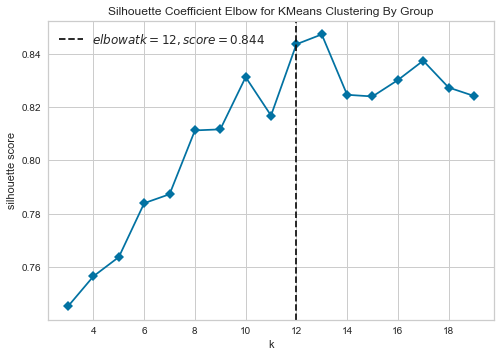

In [1012]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
metric_val = 'silhouette'
visualizer = KElbowVisualizer(model, k=(3,20),title="Silhouette Coefficient Elbow for KMeans Clustering By Group", metric=metric_val,timings=False)
# , metric='calinski_harabasz','silhouette'
visualizer.fit(dfw_grouped_clustering_bygroup)
visualizer.show()
#visualizer.show(outpath="kelbow_visualizer_bygroup.png")

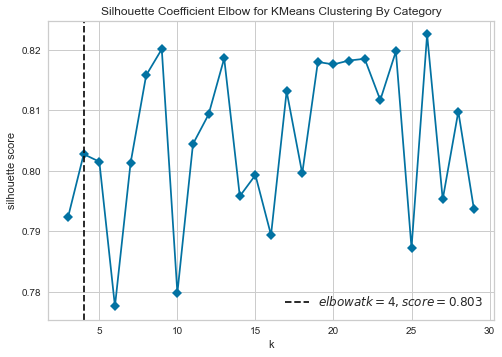

In [1013]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,30),title="Silhouette Coefficient Elbow for KMeans Clustering By Category", metric=metric_val,timings=False)
visualizer.fit(dfw_grouped_clustering)
visualizer.show()
#visualizer.show(outpath="kelbow_visualizer_bycategory.png")

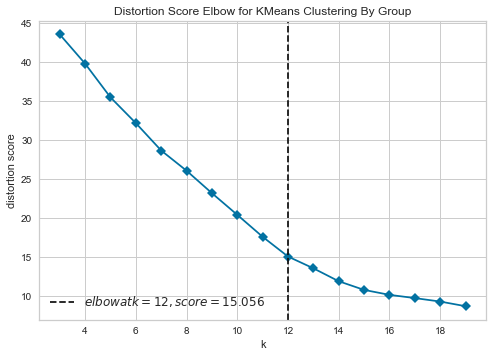

In [1014]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
metric_val = 'distortion'
visualizer = KElbowVisualizer(model, k=(3,20),title="Distortion Score Elbow for KMeans Clustering By Group", metric=metric_val,timings=False)
# , metric='calinski_harabasz','silhouette'
visualizer.fit(dfw_grouped_clustering_bygroup)
visualizer.show()
#visualizer.show(outpath="kelbow_visualizer_bygroup.png")

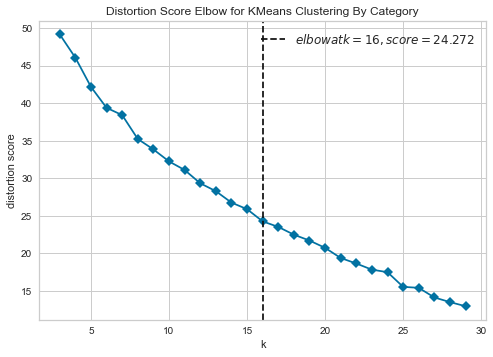

In [1015]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,30),title="Distortion Score Elbow for KMeans Clustering By Category", metric=metric_val,timings=False)
visualizer.fit(dfw_grouped_clustering)
visualizer.show()
#visualizer.show(outpath="kelbow_visualizer_bycategory.png")